# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Pymc3 Introduction 
Week 8 | Lesson 4.1 and Lab 4.2

We can convert frequentist models we have been using before to their Bayesian counterparts. In this lesson & lab we will be starting incrementally: replacing the frequentist t-test with Bayesian estimation.


### Load packages

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
%matplotlib inline

#### pymc3 is the bayesian modeling package used in this lab

`pip install pymc3`

There is also still an active pymc (which is pymc version 2) which has a different syntax. pymc3 is the newer version which will eventually replace it. If you get an error relating to graphviz you can try: `pip install pydot-ng`. pymc3 also uses theano, which compiles code into C for efficient run-time.

In [2]:
import pymc3 as pm

g++.exe": unrecognized option `-shared'
g++.exe": installation problem, cannot exec `cpp': No such file or directory



00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

Exception: Compilation failed (return status=1): g++.exe": unrecognized option `-shared'. g++.exe": installation problem, cannot exec `cpp': No such file or directory. 

### Starcraft dataset

This dataset has records of different player statistics while they are playing a computer game called Starcraft competitively. There are a variety of columns that are described in detail within the `skillcraft_description.txt` folder contained inside the same folder. For the examples in this lab we will be using APM (Actions Per Minute) and Age, but you can look at other variables as well.

In [3]:
star = pd.read_csv('./assets/datasets/skillcraft1_dataset.csv')
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


##  Bayesian Estimation Supersedes the T-Test (BEST)

In the following code, we will be using Bayesian posterior estimation to look at the difference in APM (Actions Per Minute) between 19 year old players and 26 year old players. We will replace the t-test with the normal distribution since it is easier to parameterise and we have a reasonable sample size. Previously we talked about how you could do a z-test (for large samples) or a t-test (for samples <30). Typically you will have some null hypothesis and, based on a distribution (eg Normal or t-distribution) you will say whether the value you observed is significantly different from the null hypothesis. 

We can approach this differently with pymc3 from a Bayesian standpoint. Since we would typically (in this frequentist viewpoint) reject a hypothesis at some arbitrary p-value (such as 0.05), we have a black-and-white situation. This can be helpful or it can be confusing and weakly informative. Bayesian statistical testing will instead gives us separate parameters that tell us how distinct two groups are, as well as how confident we are in that assessment. This can hence be more informative.

This approach is described in John Kruschke's 2012 paper on the subject [here](./assets/papers/BEST.pdf). In the tech business world, this approach is most often used for A/B testing. That's more informative then the frequentist testing because of the inherent updating, which can allow us to apply credible intervals and potentially stop the A/B test earlier than we would under a frequentist approach. Furthermore our results are more readily interpretable (though they are certainly more difficult to get to, but once you have a flow in a business then you can apply the same A/B test code trivially).

### Load Age = 19 year olds and Age = 26 year olds as two separate groups to test/compare

In [4]:
# We're separating out our data into these two groups to test the
# differences between them (are they significantly different?)

apm19 = star[star.Age == '19']["APM"].values
apm26 = star[star.Age == '26']["APM"].values

## Set up the bayesian model and priors on means

In [5]:
# First we find the mean and standard deviation of APM regardless of age group. 
# We are going to use these values to inform our priors, or current beliefs 
# about the actions per minute (APM)

mean_prior_mean = star["APM"].mean()
mean_prior_std = star["APM"].std()

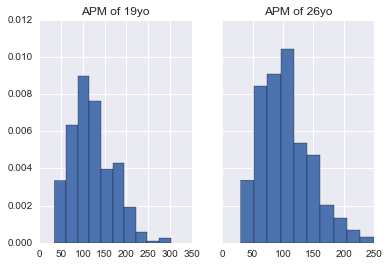

In [6]:
# What does this data look like?

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(apm19, normed=True)
ax1.set_title("APM of 19yo")
ax2.hist(apm26,  normed=True)
ax2.set_title("APM of 26yo")
plt.show()

In [7]:
# Frequentist approach: t-test with normal distributions
from scipy import stats

stats.ttest_ind(apm19, apm26, equal_var = False)

Ttest_indResult(statistic=3.7398403001020992, pvalue=0.00022175643666113402)

The first thing we are going to set up is our _prior belief_ about the mean actions per minute for our 19 year olds and 26 year olds. These are not fixed values, but rather normal distributions covering a range of possible values for the mean actions per minute for each group with varying likelihoods (i.e. highest likelihood at the mean and scaling down either side). We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players because our prior belief for each group's mean actions per minute is the same.

In [8]:
# model specifications in PyMC3 are wrapped in a with-statement
# here we first instantiate the model object and name it model
# these normals are the same normal distributions for each group, which are our priors
# so they have the same parameters (the 'APM_19yo_mean' and 'APM_26yo_mean' are just the names we give them)

model=pm.Model()

with model:
    group19_mean = pm.Normal('APM_19yo_mean', mean_prior_mean, sd=mean_prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', mean_prior_mean, sd=mean_prior_std)

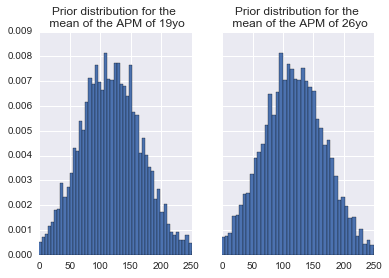

In [9]:
# Now that we have set these priors, we can access them 

samples19 = [group19_mean.random()[0] for i in range(5000)]
samples26 = [group26_mean.random()[0] for i in range(5000)]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(samples19, bins=70, normed=True)
ax1.set_title("Prior distribution for the \n mean of the APM of 19yo")
ax1.set_xlim([0,250])
ax2.hist(samples26, bins=70, normed=True)
ax2.set_title("Prior distribution for the \n mean of the APM of 26yo")
ax2.set_xlim([0,250])
plt.show()

## Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group. In fact, we have to have a prior belief about the distribution of APM for each age group. Our standard deviation priors will be uniformly distributed from close to 0 up to 100. This is an uninformative prior, saying that we believe all standard deviations in those ranges to be equally likely.

In [10]:
# Having already instantiated the model and set the mean parameters in the previous cell,
# we now set the standard deviation for each case (also the same) as our prior which is
# uninformative in that it is uniform over the range 0-100

std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    group19_std = pm.Uniform('APM_19yo_std', lower=std_prior_lower, upper=std_prior_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=std_prior_lower, upper=std_prior_upper)

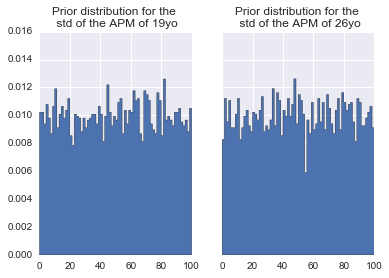

In [11]:
# We access our std priors and plot those also for clarity

samples19 = [group19_std.random()[0] for i in range(5000)]
samples26 = [group26_std.random()[0] for i in range(5000)]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(samples19, bins=70, normed=True, histtype="stepfilled")
ax1.set_title("Prior distribution for the \n std of the APM of 19yo")
ax1.set_xlim([0,100])
ax2.hist(samples26, bins=70, normed=True, histtype="stepfilled")
ax2.set_title("Prior distribution for the \n std of the APM of 26yo")
ax2.set_xlim([0,100])
plt.show()

### Set up the APM (Actions Per Minute) distributions for groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the posterior distributions for the APMs after we have observed the data. For each group we set up a `pm.Normal` distribution to represent the posterior APM. The mean `mu=` will be our prior belief distribution of the mean for that group. Likewise the `sd=` will be the prior distribution for standard deviation of APM for that group. 

Lastly, we give the posteriors an `observed=` parameter which is the actual APM data. When we "fit" this model using MCMC (Markov Chain Monte Carlo, a random sampling process), the two posterior distributions will be updated according to our prior beliefs and our data.

In [12]:
# now we set up Bayes rule; the 'observed' are the data points that are passed to the likelihood function
# for the given hypothesis (some mean and standard deviation) which we combine with the priors
# for that hypothesis  to return our posterior probability distribution
# for that given hypothesis, and then interated over all tested hypotheses

with model:
    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)

### Defining additional metrics

The `pm.Deterministic` distributions are defined from other distributions in the model. For example, below we set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated. Effect size is a normalised measure of the strength of a difference between the means. We take the difference between means and divide by the pooled standard deviation. Our effect size is guaranteed to lie betweeen -1 and 1, with 0 indicating no difference.

In [13]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group19_std - group26_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((group19_std**2 + group26_std**2) / 2))

### Fitting the model with MCMC

When we call `trace = pm.sample(...)` we are starting the process of Markov Chain Monte Carlo (MCMC) estimation of posteriors. Essentially it is a sampling algorithm that lets us construct arbitrary posterior distributions given our data and priors. You'll see "NUTS" being printed out when it is run, along with a progress bar. "NUTS" stands for No U-Turn Sampler and is a state-of-the-art MCMC algorithm. The "trace" is a collection of all the values on the posterior distribution visited by the MCMC sampling. The values in the trace define the posterior distribution.

What we do here is sample across different means and standard deviations (which are our hypotheses) and test how likely each individual data point in the dataset is given the hypothesis of that mean and standard deviation. Then we compute the product of all of those likelihoods for each data point in the dataset for that one given hypothesis (mean, standard deviation pair) and we now have a posterior probability for that given hypothesis (mean, standard deviation pair) across all data points. However we are really interested in the space of all probabilities across all given hypotheses, so we compute this for each pairing of mean and standard deviation in a random fashion that is dependent on the relative likelihoods, such that more samples are taken from higher likelihood regions of the hypothesis space (this is the Markov Chain Monte Carlo). This is then what creates the plots below, shown in two dimensions to separate out mean and standard deviation (but really we have a three dimensional probability space).

Note that typically you would discard the first few thousand points in the trace as these likely represent points prior to a good convergence towards highest likelihood (actually in this case it does not make a noticeable difference but this is best practice). Here I set a burned_trace which is the last 10000 samples.

In [ ]:
with model:
    trace = pm.sample(25000, njobs=4)

burned_trace=trace[10000:]

In [116]:
# our trace is 25000 sets of means, standard deviations
# that were sampled and posteriors calculated 

burned_trace[0]

{'APM_19yo_mean': 118.6147138405216,
 'APM_19yo_std': 48.964955809461891,
 'APM_19yo_std_interval_': -0.041611931613068101,
 'APM_26yo_mean': 111.54135219999401,
 'APM_26yo_std': 40.694604837963801,
 'APM_26yo_std_interval_': -0.3768505212943441,
 'difference of means': 7.0733616405275939,
 'difference of stds': 8.2703509714980896,
 'effect size': 0.15711565622026175}

### Plotting posteriors and result distributions



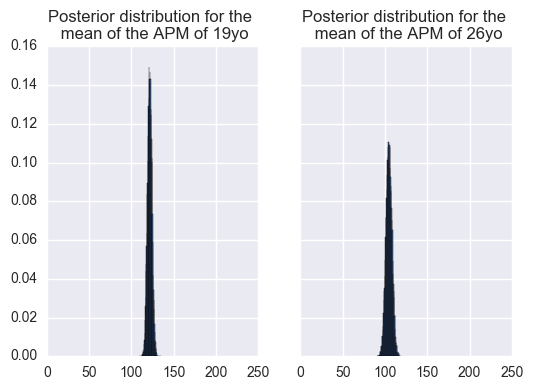

In [117]:
# We can plot the posteriors of the means here on the same scale as we
# plotted the priors of the means

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(burned_trace["APM_19yo_mean"], bins=70, normed=True)
ax1.set_title("Posterior distribution for the \n mean of the APM of 19yo")
ax1.set_xlim([0,250])
ax2.hist(burned_trace["APM_26yo_mean"], bins=70, normed=True)
ax2.set_title("Posterior distribution for the \n mean of the APM of 26yo")
ax2.set_xlim([0,250])
plt.show()

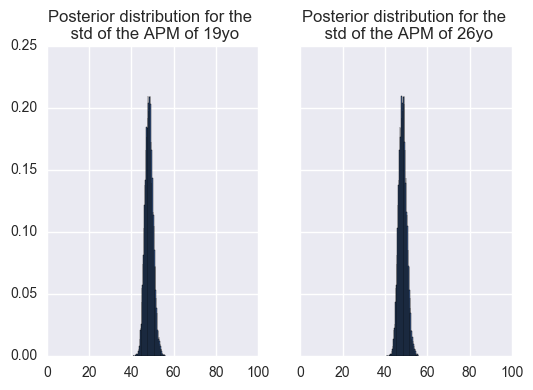

In [118]:
# We access our std priors and plot those also for clarity

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(burned_trace['APM_19yo_std'], bins=70, normed=True)
ax1.set_title("Posterior distribution for the \n std of the APM of 19yo")
ax1.set_xlim([0,100])
ax2.hist(burned_trace['APM_19yo_std'], bins=70, normed=True)
ax2.set_title("Posterior distribution for the \n std of the APM of 26yo")
ax2.set_xlim([0,100])
plt.show()

But actually pymc3 comes with convenient methods for plotting posteriors. This gives us a probability density. Below we plot our posterior means and standard deviations and statistics about the distributions are automatically given to us on the plots. The HPD is the Highest Posterior Density interval. This gives us a bayesian "credible interval" which is the corollary to the frequentist "confidence interval". The 95% HPD says that the 95% highest density points on the distribution fall within that range.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13b7a9b90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12e5c53d0>], dtype=object)

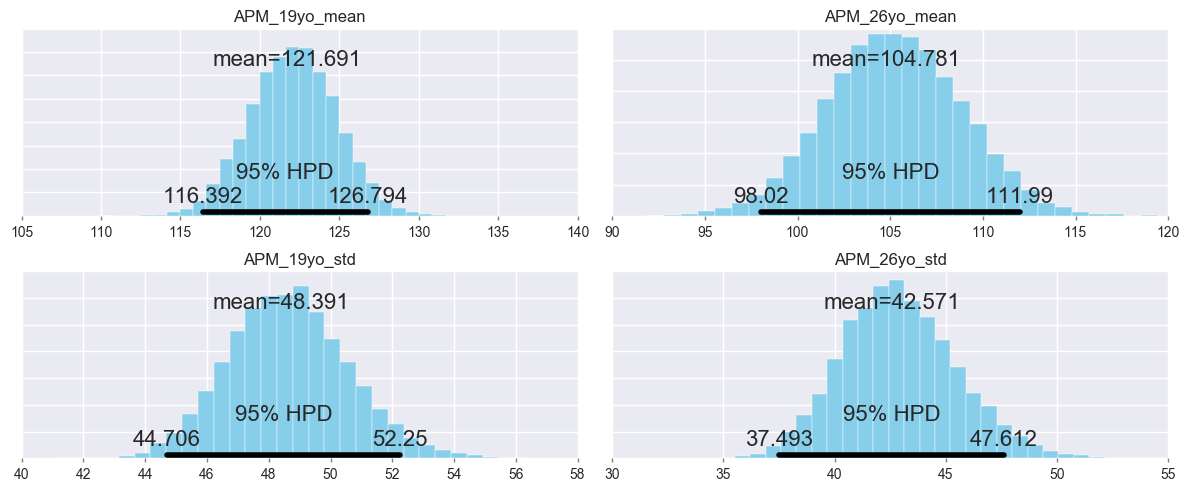

In [119]:
pm.plot_posterior(burned_trace,
                  varnames=['APM_19yo_mean', 'APM_26yo_mean', 'APM_19yo_std', 'APM_26yo_std'],
                  color='#87ceeb')

We can also plot out our distributions that we defined to explicitly measure the statistics we were interested in, like the difference in mean APM between the groups. The `ref_val` will plot a vertical bar at any value you like to give you a visual reference. In this case, we will choose 0 since we want to see if a portion of our mean difference distribution overlaps 0.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13782ba50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13c135d50>], dtype=object)

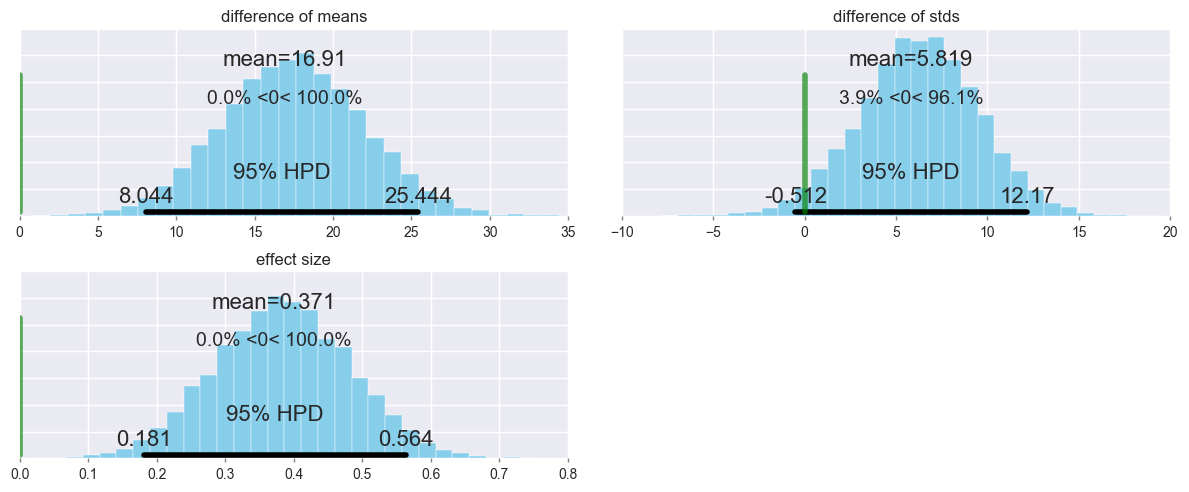

In [120]:
pm.plot_posterior(burned_trace,
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [128]:
# If we just want to return one very simple result, we can compare the means and find the
# proportion that have a positive difference (rather than a negative one)

print("Probability mean of 19yo group is larger than mean of 26yo group for APM:", np.mean(burned_trace['difference of means'] > 0))

('Probability mean of 19yo group is larger than mean of 26yo group for APM:', 1.0)


Lastly, you can use the `pm.summary` command to print out a text representation of the statistics for the posterior distributions above.

In [122]:
pm.summary(burned_trace,
           varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  16.910           4.487            0.014            [8.044, 25.444]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.223          13.872         16.909         19.952         25.655


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.819            3.242            0.010            [-0.512, 12.170]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.616         3.716          5.861          8.013          12.074


effect size:

  Mean             SD               MC Error         95% HP

Wow, that was a lot of work compared with one line in scipy! But we returned much more informative parameters than simply a yes-no based on a 0.05 p-value. We're also less likely to make errors due to confusion (which kind of test, what p-value, is it two sided or one sided etc etc). Furthermore, we can use the power of Bayesian updating to keep changing our posterior as we get new data. This is why Bayesian analysis is so often used for A-B testing; it forms a natural way to constantly update our results and return confidences on those results that are more easily interpretable for the business than p-values. But there's no getting around the computation required for this approach, and that's why frequentist hypothesis testing is also widely used.

## Perform your own comparison with pymc3

Following the code above, choose groups and values to compare by group using the same Bayesian posterior estimation process. For example, try different age groups and comparing their Hours per Week or another measure. Try playing around with the parameters for the priors. Get a feel for how pymc3 is working and take a look at the documentation [here](http://pymc-devs.github.io/pymc3/index.html) as well as Kruschke's paper [here](./assets/papers/BEST.pdf)